# Homework 2: J&S Experimental Loops
## Travis Hammond - s2880024

First, let's import everything we will need and set a seed for reproducible results. We should also be using NumPy's random generator instead of directly accessing the methods from the random module.

Note that I forked the git repository containing the model.py and dmchunk.py files and then moved those into a subdirectory named ACTR. I then create further subdirectories named HW1, HW2, etc and call my code via main.py located in the root directory. This way I conform to best practices regarding pythonic packaging while also being able to synchronize to any changes made to model.py and dmchunk.py, but it might make you run into some ImportErrors.

In [1]:
from pathlib import Path
from typing import List
import sys; sys.path.append(Path().resolve().parent.as_posix())

from ACTR.model import Model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncexpon

rng = np.random.default_rng(seed=111)

Then, we define a function to initialize an ACT-R model. These models can be thought of as the subjects, or participants, and thus they should be labeled with a unique id. If participants are later assumed to have some knowledge prior to partaking  in the experiment, that can be initialized here.

In [2]:
def init_model(
            id: int
        ) -> Model:
    """We create a (model of a) participant here.

    This gives us a way to initialize them with some prior knowledge if
    necessary, and give them a unique id.

    Args:
        id (int): The unique id of the participant.

    Returns:
        Model: A fresh subject to experiment on.
    """
    subj = Model()
    subj.id = id
    return subj

The do_trial function fully defines the process of a trial, as well as the cognitive process the participant goes through. The participant is presented with some stimuli at some intervals, and is then expected to reproduce the sample interval. 

I use the truncated exponential distribution provided by scipy to sample the variable delay. The production time is measured from halfway through the second flash, and thus the second half overlaps with the production time and is not doubly added to the model time.

In [3]:
def do_trial(
            subj: Model,
            sample_interval: float
        ) -> float:
    """This function takes a subject and an interval time, and goes through
    the process of an experiment trial.

    Args:
        subj (Model): The subject which will do the trial.
        sample_interval (float): The interval time defining the trial.

    Returns:
        float: The (re)production time.
    """
    # "Each trial began with the presentation of a central fixation point for 1s,"
    subj.time += 1
    # "followed by the presentation of a warning stimulus ..."
    # "After a variable delay ranging from 0.25-0.85s drawn randomly from a
    # truncated exponential distribution, ..."
    subj.time += truncexpon(0.6, 0.25).rvs(1, random_state=rng)
    # "two 100ms flashes separated by the sample interval, t_s, were presented."
    subj.time += 0.1  # READY
    subj.time += sample_interval
    # "Production times, t_p, were measured from the center of the flash, (that
    # is, 50ms after its onset) to when the key was pressed"
    subj.time += 0.05  # SET

    # implement cognitive model here
    production_time = sample_interval

    subj.time += production_time  # GO
    return production_time

Finally, the complete experiment is defined here and consists of many trials. In particular, we have three conditions defined by discrete uniform distributions over different time intervals. A discrete uniform distribution of 11 samples over some interval is identical to 11 evenly spaced values in that same interval (given by np.linspace).

Each subject goes through a learning phase and then a testing phase with each of the three conditions (in random order). We replace the adaptive learning phase with a simple fixed number of training trials. For each condition, a sample interval is drawn uniformly from the discrete distribution and a trial is completed.

The data is recorded identically to the given data, produced by the authors of the paper.

In [4]:
def do_experiment(
            participants: List[Model],
            n_test_trials: int,
            n_train_trials: int
        ):
    """Perform the experiment on a list of participants.

    Args:
        participants (list(Model)): The volunteering participants.
        n_test_trials (int): The number of testing trials.
        n_train_trials (int): The number of training trials.

    Returns:
        pandas.DataFrame: The collected data as a pandas DataFrame.
    """

    # "All priors were discrete uniform distributions with 11 values, ranging
    # from 494–847 ms for the short, 671–1,023 ms for the intermediate and
    # 847–1,200 ms for long prior condition."
    prior_distributions = np.array([
        (1, np.linspace(start=0.494, stop=0.847, num=11)),
        (2, np.linspace(start=0.671, stop=1.023, num=11)),
        (3, np.linspace(start=0.847, stop=1.200, num=11)),
    ], dtype='object')

    # create the DataFrame
    row_idx = 0
    data = pd.DataFrame(columns=[
        'Subj', 'Cond', 'line', 'Trial', 'Ts', 'Tp', 'MaxTrial', 'Main'
    ])

    # each subject goes through the experiment
    for subj in participants:

        # "For each subject, the order in which the three prior conditions were
        # tested was randomized."
        rng.shuffle(prior_distributions)
        for condition, distribution in prior_distributions:

            # "For each prior condition, subjects were tested after they
            # completed an initial learning stage." (here: train, then test)
            for trial_idx in range(1, n_train_trials + n_test_trials + 1):

                # "sample intervals are drawn randomly from one of three
                # partially overlapping discrete uniform prior distributions."
                sample_interval = rng.choice(distribution)

                # perform the actual trial
                production_time = do_trial(subj, sample_interval)
                # don't give feedback

                # record the results just like the authors did
                data.loc[row_idx] = [
                    subj.id + 1,
                    condition,
                    row_idx + 1,
                    trial_idx,
                    sample_interval,
                    production_time,
                    n_train_trials + n_test_trials,
                    False if trial_idx <= n_train_trials else True
                ]
                row_idx += 1

    return data

Here we simply reproduce the plotting code from the example to later compare our results to the original data.

In [5]:
def plot(data):
    """The code to recreate the plot from the paper.

    Args:
        data (pandas.DataFrame): The pandas DataFrame of results to plot.
    """
    # Remove training trials
    data = data[data['Main'] == True]
    # Calculate mean Tp by condition
    mean_tp = data.groupby(['Cond', 'Ts'])['Tp'].mean().reset_index()
    # Determine axes limits
    yrange = np.multiply(
        (min(mean_tp['Ts']), max(mean_tp['Ts'])),
        [0.95, 1.05]
    )

    # Subset data for plotting
    cond1 = mean_tp.loc[mean_tp['Cond'] == 1]
    cond2 = mean_tp.loc[mean_tp['Cond'] == 2]
    cond3 = mean_tp.loc[mean_tp['Cond'] == 3]

    # Add jitter noise
    jitter = data.copy()
    jitter['Ts'] = jitter['Ts'] + rng.uniform(-5, 5, len(data))
    cond1_jitter = jitter.loc[jitter['Cond'] == 1]
    cond2_jitter = jitter.loc[jitter['Cond'] == 2]
    cond3_jitter = jitter.loc[jitter['Cond'] == 3]

    # Make plot
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set(xlim=yrange, ylim=yrange)
    fig.gca().set_aspect('equal', adjustable='box')

    ax.set_xlabel('Sample interval (ms)')
    ax.set_ylabel('Production time (ms)')

    ax.plot(yrange, yrange, linestyle='--', color='gray')

    ax.scatter(
        cond1_jitter['Ts'], cond1_jitter['Tp'],
        marker='.', color='black', alpha=0.025, label=None
    )
    ax.scatter(
        cond2_jitter['Ts'], cond2_jitter['Tp'],
        marker='.', color='brown', alpha=0.025, label=None
    )
    ax.scatter(
        cond3_jitter['Ts'], cond3_jitter['Tp'],
        marker='.', color='red', alpha=0.025, label=None
    )

    ax.plot(
        cond1['Ts'], cond1['Tp'],
        color='black', marker='o', label="short"
    )
    ax.plot(
        cond2['Ts'], cond2['Tp'],
        color='brown', marker='o', label="intermediate"
    )
    ax.plot(
        cond3['Ts'], cond3['Tp'],
        color='red', marker='o', label="long"
    )

    ax.legend(title='Prior condition', loc=4)
#     plt.show()

Now, after running the experiment, we can compare the simulated data to the original data. And indeed, we see very similar data except that the production time equal the sample intervals resulting in the identity line. Because the intervals are discrete and overlap, the full range of the 11 points is not always visible.

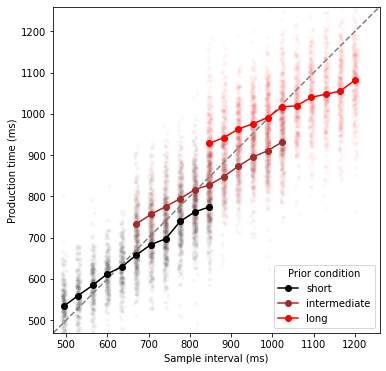

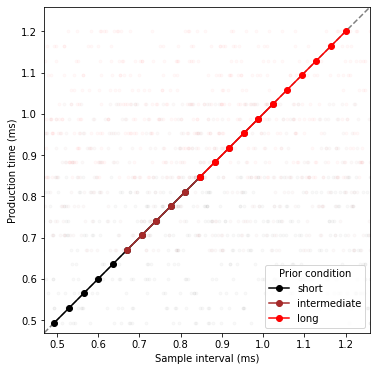

In [6]:
def main(n_participants=5, n_train_trials=500, n_test_trials=1000):
    # create the participants, do the experiment and record the data
    participants = [init_model(id) for id in range(n_participants)]
    simulated_data = do_experiment(participants, n_test_trials, n_train_trials)
#     simulated_data.to_csv(Path() / 'model_data.csv', index=False)

    # load the original data, and plot both to compare
    original_data = pd.read_csv(Path() / "HW2-dataJS.csv")
    plot(original_data)
    plot(simulated_data)


if __name__ == '__main__':
    main()
